# ImageAnnotationChallenge

## Overview : 概要

### Project target : プロジェクト目標

- 普通のECサイトにおける検索機能について､改善方法を検討する
- 画像認識によるタグ付けの開発を優先する
- メンバーも実際のプロジェクト経験をもらいつつ､デモプロジェクトの開発と記事を作成できるまで頑張る

In English:
- Consider the ways how to improve search function on e-commerce site.
- Prioritize the development of tagging by image recognition.
- The members will do our best until creating an article and developing demo project, gaining project experience.


### Study scope : 学習範囲

* Note記事を書く
* 画像認識によるタグ付けを優先して開発する
* 日本語･英語両方タグ付けできるようにする

In English:

* Write a note article
* Develop tagging system by image recognition in priority
* The system becomes able to tag  in Japanese and English


### Repository

* [TOP](https://github.com/ryu-i-engineer/ImageAnnotationChallenge)
* [Projects](https://github.com/ryu-i-engineer/ImageAnnotationChallenge/projects/2)

## Reference

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/segmentation

### About Transfer learning

#### Domain problem

- [転移学習：機械学習の次のフロンティアへの招待](https://qiita.com/icoxfog417/items/48cbf087dd22f1f8c6f4#%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E3%81%AE%E5%8F%96%E3%82%8A%E7%B5%84%E3%82%80%E5%95%8F%E9%A1%8C)

## Dataset

### Using web scraping

- https://jp.misumi-ec.com/vona2/mech_screw/M3303000000/?rid=c21_top_4_M3303000000
- https://www.ipros.jp/product/
- https://ecclab.empowershop.co.jp/archives/2536

### Fasteners : ネジ･ボルト･座金･ナット

#### Hand tools for screws : ネジ用工具

#### Hair pins & Cotter pins : スナップピン･割りピン

#### Inserts : インサート

- Tangless inserts : タングレスインサート
- Threaded inserts : ネジインサート
- Tools for Tangless inserts : タングレスインサート専用工具
- Tools for threaded inserts : ネジインサート用工具

#### Machine keys : マシンキー

#### Nuts : ナット

- Cylindrical nuts: 丸ナット
- Domed & Acorn nuts : 袋ナット
- Flanged nuts : フランジ付きナット
- Hex nuts : 六角ナット
- High nuts(Spacers) : 高ナット(スペーサー)
- Knurled nuts : ローレットナット
- Lock nuts : ロックナット･ゆるみ止めナット
- Non-metal nuts : 樹脂ナット
- Rectangular & Square nuts : 四角ナット
- Wing nuts : 蝶ナット
- Rivet nuts : リベットナット
- Weld nuts : ウェルドナット(溶接ナット)
- Clinching nuts : クリンチングナット
- Clip nuts :クリップナット
- Cap nuts : キャップナット
- Washer based nuts : 歯付き座金ナット･溝付き六角ナット
- Gauge nuts : ゲージナット

#### Retaining rings : 止め輪･リング

#### Screws & Bolts : ネジ･ボルト

- Captive Washer Screws : 座金組み込みネジ
- Cross Recessed Bolts : 低頭ボルト
- Eye Screws, Eye Bolts & Eye Nuts : アイボルト･でんでんボルト
- Fastener Accessories : ネジ用アクセサリー
- Fully-Threaded Bolts & Stud Bolts : 全ねじ･スタッドボルト
- Hex Bolts : 六角ボルト
- Hex socket button head cap screws : 六角穴付ボタンボルト
- Hex socket flat head cap screws : 六角穴付皿ボルト
- Hex socket head cap screw: 六角穴付ボルト
- Micro Screws & Precision screws : マイクロネジ･微細ネジ
- Plastic & Ceramic screws : 樹脂ネジ･セラミックネジ
- Self tapping screws : タッピングネジ･タップタイト･ハイテクネジ
- Set screws : 止めネジ
- Small head bolts : 小径ボルト
- Space Saving bolts : 低頭ボルト
- Strippers, Reamers & Shoulder bolts : ストリッパー･リーマ･ショルダーボルト
- Tamper Resistant screws : いたずら防止ネジ
- Vented Screws : 貫通穴付ボルト
- Wing, Thumb & Ornamental screws : 蝶ボルト･つまみネジ･化粧ビス

#### Screw plug hardware : スクリュープラグ

#### Shims : シム

- Rectangular shims : 角シム
- Shim plates : シムプレート
- Shim rings : シムリング
- Shim tape : シムテープ

#### Wahers : 座金(ネジ用ワッシャ)

- Metal washers : 金属ワッシャ
- Non-metal washers & Collars : 非金属･樹脂ワッシャ

### Wiring components : 配線部品

#### LAN & Industrial Network cables : LAN･産業用ネットワークケーブル

- LAN cable : LANケーブル(コネクタ付)
- LAN / Network cable : LAN･省配線ネットワークケーブル(ケーブル単体)
- Fiber Optic cable accessories : 光ファイバケーブル(オプションその他)
- LAN cable & connector accessories : LANケーブル･コネクタオプション
- Network cable adapters : LAN中継･延長用アダプタ
- Network cable connectors : LANコネクタ
- Telephone cable : 電話線(RJ11)
- Fiber optic cable : 光ファイバケーブル


#### Equipment specific cables : 機器対応ケーブル

- AC servo motor cables : ACサーボモータ用ケーブル
- Cordset Accessories : ハーネス(オプション)
- I/O board cables : I/Oボード対応ケーブル
- Image sensor cables : 画像センサ対応ケーブル
- PLC cables : PLC対応ケーブル
- Relay terminal cables : リレーターミナル対応ケーブル
- Sensor cordsets : センサ対応ケーブル
- Single Axis Robot cables : 単体ロボットケーブル
- Stepper motor cables : ステッピングモータ用ケーブル
- Touch panel cables : タッチパネル対応ケーブル
- Solenoid valve compatible cable : 電磁弁対応ケーブル

#### Cordsets : コネクタ付ケーブル(汎用)

- Circular cordsets : 丸形コネクタ付ケーブル
- Coaxial cordsets : 
- Conversion & branching cordsets : 変換･分岐ケーブル
- Nylon connector cordsets : ナイロンコネクタ付ケーブル
- Square cordsets : 角型コネクタ付ケーブル

#### Cable accessories : ケーブルアクセサリー

- Cable Accessories : ケーブルアクセサリー
- Conductive tape : 導電性テープ
- Electrical tape : テープ･シール

#### Cable gland components : ケーブルグランド

#### Cable bushings, Clip & stickers : ケーブルブッシュ･クリップ･ステッカー


- Cable bushings: ケーブルブッシュ
- Cable clips : ケーブルクリップ
- Cable stickers : ケーブルステッカー

#### Cable organization : 結束バンド

- Cable ties : 結束バンド
- Cable tie mounts & accessories : 結束バンド固定具･オプション

#### Computer & AV cables : RS232･パソコン･AVケーブル(OA機器対応)

- Audio Video cable components : AVケーブル
- Display cable components : ディスプレイケーブル
- Printer cable components : プリンタケーブル
- PS/2 Cable components : PS/2規格ケーブル
- RS232C cables : RS232Cケーブル
- SCSI cable components : SCSIケーブル
- USB cable supplies : USBケーブル
- Antenna cable : アンテナケーブル

#### Crimp terminal components : 圧着端子

- Crimp terminals : 圧着端子
- Crimp terminal accessories : 圧着端子(オプション･その他)

#### Electrical conduits : 保護管

- Metal conduits : 金属管
- Metal conduit accessories : 金属管オプション
- Plastic conduits : 樹脂管
- Plastic conduits accessories : 樹脂管オプション

#### Electrical Tubing & sleeving : チューブ

- Braided sleeves : 編組チューブ
- Cable sleeving : シート型チューブ
- Electrical tubing accessories : チューブオプション
- General Purpose tubing : 汎用チューブ
- Heat shrink tubing : 熱収縮チューブ
- Spiral wraps : スパイラルチューブ

#### Electrical wiring tools : 汎用工具

- Cable tie tools : 結束工具
- Crimping & IDC tools : 圧着工具･圧接工具
- Electrical wiring tool accessories : 汎用工具(オプション･その他)
- Wire cutting tools : 切断工具
- Wiring connection screwdrivers : ドライバー(配線接続用)
- Wiring tweezers & wranches : ピンセット･レンチ
- Wiring stripper tools : 電線剥き工具

#### Screw & spacer components

#### Soldering supplies

- Soldering tools : ハンダ付け工具
- Soldering iron holders : ハンダごてホルダー

#### Specialized wiring tools : 専用工具

- Connector tools : コネクタ専用工具
- Specialized wiring tool accessories : 専用工具(オプション･その他)
- Terminal removal tools : 端子引抜工具

#### Wire & Cable

- Coaxial cables: 同軸ケーブル
- Coiled cords : カールコード
- Control & Instrumentation cables : 制御･計装ケーブル
- Environmentally friendly cables : エコ電線ケーブル
- Flexible robot cables : ロボットケーブル
- Hook-Up wires : 電気･電子･通信機器用絶縁電線
- Power cables : 電力ケーブル
- Ribbon cables : フラットケーブル
- Information communication cable : 情報通信ケーブル
- Wire storage : 電線収納具
- Disaster prevention alarm cable : 防災用警報用ケーブル
- LAN / Network cable : LAN･省配線ネットワークケーブル(ケーブル単体)

#### Wiring connectors : コネクタ

- Cicular connectors : 丸形コネクタ
- Coaxial connectors : 同軸コネクタ
- Connector accessories : コネクタ(オプション･その他)
- Connector Adapters : 変換コネクタ
- Connector caps : コネクタ用キャップ
- Connector sets : コネクタセット
- Contacts & Pins : コンタクトピン
- Nylon connectors : ナイロンコネクタ
- Rectangular connectors : 角型コネクタ


#### Wire ducts & cable raceways

- Cable raceways : モール
- Cable raceway accessories : モールオプション
- Wire ducts : ワイヤダクト
- Wire duct accessories : ワイヤダクトオプション

## Dummy data

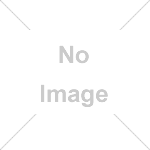
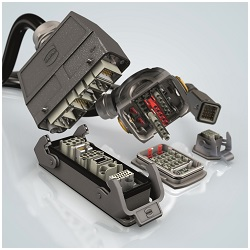

## Codes

### Try TensorFlow tutorial

### Using TF Hub for Transfer learning

#### Prepare

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17047442711359144442
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4853137408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6898635498861475831
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [ ]:
import tensorflow_hub as hub

##### Download classification

In [ ]:
# Download classification
# classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" # MobileNet
# classifier_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5" # ResNet-152
classifier_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2" # EfficientNet V2

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

#### Execute one image file

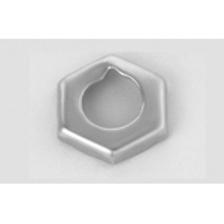

In [ ]:
import numpy as np
import PIL.Image as Image

# grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
# grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = Image.open("./inputs/misumi_dataset/nuts_cap/000001.jpg").resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
# Get batch dimension and input image to model.
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1000)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

844

#### Decode the predict result

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

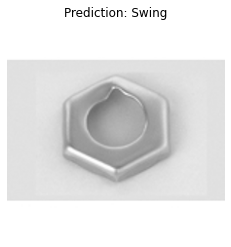

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

#### Simple transfer learning

In [ ]:
# data_root = tf.keras.utils.get_file(
#   'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    untar=True)
data_root = "./inputs/misumi_dataset"

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 18204 images belonging to 153 classes.


In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 153)


#### 分類器で画像をバッチ処理する

In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1000)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['lens cap', 'rotisserie', 'drum', 'swing', 'rugby ball', 'perfume',
       'sports car', 'sports car', 'rotisserie', 'screen',
       'suspension bridge', 'Polaroid camera', 'carousel', 'piggy bank',
       'whiskey jug', 'swing', 'Model T', 'cash machine', 'screen',
       'entertainment center', 'panpipe', 'pedestal', 'lab coat',
       'lens cap', 'vase', 'switch', 'space shuttle', 'screw', 'screen',
       'canoe', 'canoe', 'cradle'], dtype='<U30')

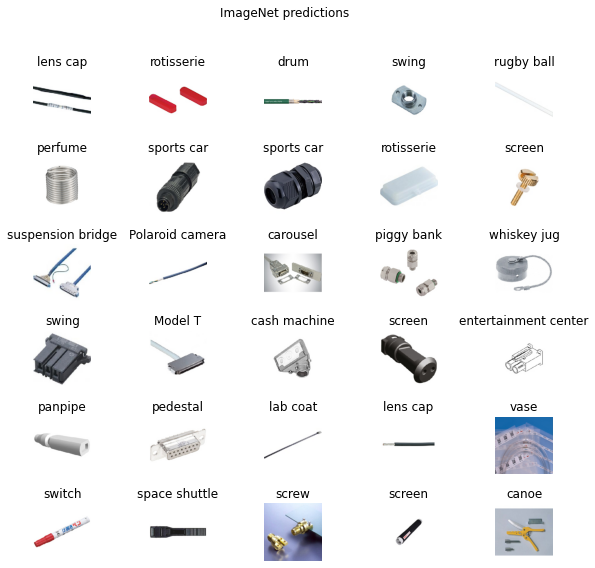

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
# feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

#### 上位の分類層を接合する

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 153)               195993    
Total params: 6,115,305
Trainable params: 195,993
Non-trainable params: 5,919,312
_________________________________________________________________


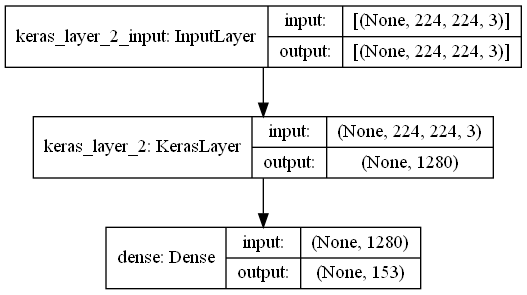

In [ ]:
# from tensorflow.keras.utils import plot_model
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
# plot_model(model, show_shapes=True)

In [ ]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 153])

#### Train model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=50,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/50
569/569 [==============================] - 298s 513ms/step - loss: 1.8600 - acc: 0.5625
Epoch 2/50
569/569 [==============================] - 44s 78ms/step - loss: 1.0235 - acc: 0.7188
Epoch 3/50
569/569 [==============================] - 45s 80ms/step - loss: 0.9886 - acc: 0.8125
Epoch 4/50
569/569 [==============================] - 47s 82ms/step - loss: 1.1769 - acc: 0.6562
Epoch 5/50
569/569 [==============================] - 47s 83ms/step - loss: 1.0601 - acc: 0.7188
Epoch 6/50
569/569 [==============================] - 48s 84ms/step - loss: 0.9153 - acc: 0.7812
Epoch 7/50
569/569 [==============================] - 47s 82ms/step - loss: 0.8856 - acc: 0.7188
Epoch 8/50
569/569 [==============================] - 47s 82ms/step - loss: 0.7039 - acc: 0.8125
Epoch 9/50
569/569 [==============================] - 47s 83ms/step - loss: 0.4884 - acc: 0.8125
Epoch 10/50
569/569 [==============================] - 47s 83ms/step - loss: 0.9967 - acc: 0.7812
Epoch 11/50
569/569 [======

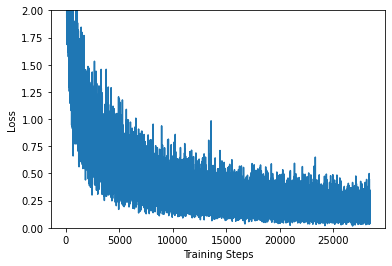

In [ ]:
# plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

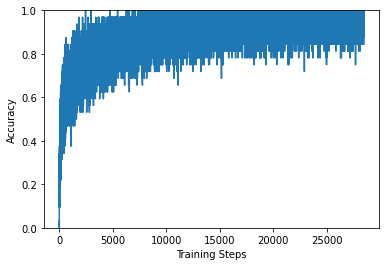

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

#### Verify the predict result

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Ac_Servo_Motor_Cables', 'Braided_Sleeves', 'Cablebushing_Clips',
       'Cablebushing_Stickers', 'Cablegland_Accessories',
       'Cablegland_Components', 'Cableorganization_Tie_Mount_Accessories',
       'Cableorganization_Ties', 'Cable_Accessories', 'Cable_Bushings',
       'Cable_Sleeving', 'Cable_Tile_Tools', 'Captive_Washer_Screws',
       'Comav_Antenna', 'Comav_Antenna_Accessories', 'Comav_Audio_Video',
       'Comav_Audio_Video_Accessories', 'Comav_Display',
       'Comav_Display_Accessories', 'Comav_Printer', 'Comav_Ps2',
       'Comav_Rs232C', 'Comav_Scsi', 'Comav_Scsi_Adapters', 'Comav_Usb',
       'Comav_Usb_Accessories', 'Comav_Usb_Adapters',
       'Comav_Usb_Smartphone', 'Conductive_Tape', 'Cordset_Accessories',
       'Cordsets_Circular', 'Cordsets_Coaxial',
       'Cordsets_Conversion_Branching', 'Cordsets_Nylon_Connector',
       'Cordsets_Square', 'Crimp_Terminal_Accessories', 'Crimp_Terminals',
       'Crimping_Idc_Tools', 'Cross_Recessed_Bolts',
       'Ele

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

In [ ]:
image_batch.shape

(32, 224, 224, 3)

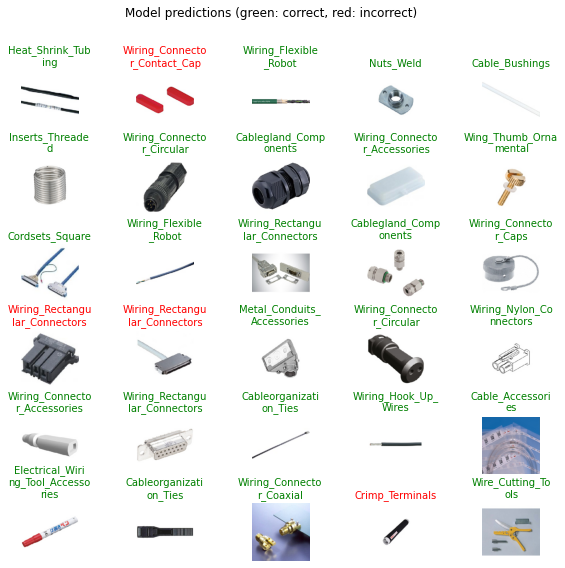

In [46]:
from textwrap import wrap
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title('\n'.join(wrap(predicted_label_batch[n].title(), 15)), color=color, fontsize=10)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#### Export model

In [45]:
from datetime import date

export_path = f"./models/{date.today().isoformat()}_2"
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: ./models/2021-10-18_2\assets


INFO:tensorflow:Assets written to: ./models/2021-10-18_2\assets


'./models/2021-10-18_2'

In [ ]:
import os
# os.listdir("./models/")
print(len(next(os.walk('./models/'))[1]))

1


In [ ]:
# reloaded = tf.keras.models.load_model(export_path)

In [ ]:
# result_batch = model.predict(image_batch)
# reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
# abs(reloaded_result_batch - result_batch).max()